In [1]:
import umsgpack
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="True"
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)
import torch
import kornia

In [2]:
print(kornia.__version__)

0.6.2


In [3]:
def compute_M(scale, image_size, bev_focal_length, bev_camera_z):
    """ image_size --> (H, W) """
    # Compute the mapping matrix from road to world (2D -> 3D)
    px_per_metre = abs((bev_focal_length * scale) / (bev_camera_z))

    # shift --> (W, H) (Where you want the output to be placed at wrt the input dimension)
    shift = ((image_size[1] / 2 * scale), image_size[0] * scale)  # Shift so that the thing is in Bottom center

    M = np.array([[1 / px_per_metre, 0, -shift[0] / px_per_metre],
                  [0, 1 / px_per_metre, -shift[1] / px_per_metre],
                  [0, 0, 0],  # This must be all zeros to cancel out the effect of Z
                  [0, 0, 1]])

    return M


def compute_intrinsic_matrix(fx, fy, px, py, img_scale):
    K = np.array([[fx * img_scale, 0, px * img_scale],
                  [0, fy * img_scale, py * img_scale],
                  [0, 0, 1]])
    return K


def compute_extrinsic_matrix(translation, rotation):
    # World to camera
    theta_w2c_x = np.deg2rad(rotation[0])
    theta_w2c_y = np.deg2rad(rotation[1])
    theta_w2c_z = np.deg2rad(rotation[2])

    R_x = np.array([[1, 0, 0],
                    [0, np.cos(theta_w2c_x), -np.sin(theta_w2c_x)],
                    [0, np.sin(theta_w2c_x), np.cos(theta_w2c_x)]], dtype=np.float)
    R_y = np.array([[np.cos(theta_w2c_y), 0, np.sin(theta_w2c_y)],
                    [0, 1, 0],
                    [-np.sin(theta_w2c_y), 0, np.cos(theta_w2c_y)]], dtype=np.float)
    R_z = np.array([[np.cos(theta_w2c_z), -np.sin(theta_w2c_z), 0],
                    [np.sin(theta_w2c_z), np.cos(theta_w2c_z), 0],
                    [0, 0, 1]], dtype=np.float)

    R = (R_y @ (R_x @ R_z))

    t = -np.array(translation, dtype=np.float)
    t_rot = np.matmul(R, np.expand_dims(t, axis=1))

    extrinsic = np.zeros((3, 4), dtype=np.float)
    extrinsic[:3, :3] = R[:3, :3]
    extrinsic[:, 3] = t_rot.squeeze(1)

    return extrinsic


def compute_homography(intrinsic_matrix, extrinsic_matrix, M):
    P = np.matmul(intrinsic_matrix, extrinsic_matrix)
    H = np.linalg.inv(P.dot(M))
    # H = P.dot(M)

    return H


def get_init_homography(intrinsics, extrinsics, bev_params, img_scale, img_size):
    extrinsic_mat = compute_extrinsic_matrix(extrinsics['translation'], extrinsics['rotation'])
    intrinsic_mat = compute_intrinsic_matrix(intrinsics[0, 0], intrinsics[1, 1], intrinsics[0, 2], intrinsics[1, 2],
                                             img_scale)
    M = compute_M(img_scale, img_size, bev_params['f'], bev_params['cam_z'])
    H = compute_homography(intrinsic_mat, extrinsic_mat, M)
    H = torch.tensor(H.astype(np.float32))
    return H

In [20]:
intrinsics = np.array([[1266.4172, 0, 816.267], [0, 1276.4172, 491.507],[0, 0, 1]])
extrinsics = {"translation": (0.0, 0.6, 1.85), "rotation": (-90, 0, 180)}
bev_params = {"f": 336, "cam_z": 26}
bev_crop = (896, 768)
front_resize = (448, 768)

In [21]:
prefix_msk = "../../data/nuScenes_panopticbev/bev_msk/bev_ortho"
prefix_vf = "../../data/nuScenes_panopticbev/vf_mask"
prefix_img = "../../data/nuScenes_panopticbev"

In [22]:
with open(os.path.join(prefix_img,'img/front.json'), 'r') as f:
    img_list = json.load(f)

In [7]:
img_list[1]

{'001;singapore-onenorth;scene-0001;73030fb67d3c46cfb5e590168088ae39;14d5adfe50bb4445bc3aa5fe607691a8.png': 'samples/CAM_FRONT/n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531883530912460.jpg'}

In [8]:
f

<_io.TextIOWrapper name='../../data/nuScenes_panopticbev\\img/front.json' mode='r' encoding='cp936'>

In [9]:
index = 5
for item in img_list[index].items():
    mask, img = item
    
with open(os.path.join(prefix_msk, mask),mode='rb') as f:
    bev_mask = Image.open(f)
    # bev_mask = bev_mask.transpose(Image.ROTATE_90)
    # bev_mask = bev_mask.resize((w // 2, h // 2))
    bev_mask = np.array(bev_mask)

with open(os.path.join(prefix_vf, mask),mode='rb') as f:
    vf_mask = Image.open(f)
    # w,h = vf_mask.size
    # vf_mask = vf_mask.resize((front_resize[1],front_resize[0]))
    vf_mask = np.array(vf_mask)

with open(os.path.join(prefix_img, img), mode='rb') as f:
    front_img = Image.open(f)
    # front_img = front_img.resize((front_resize[1],front_resize[0]))
    front_img = np.array(front_img)
# front_img = np.array(Image.open(os.path.join(prefix_img, img)))

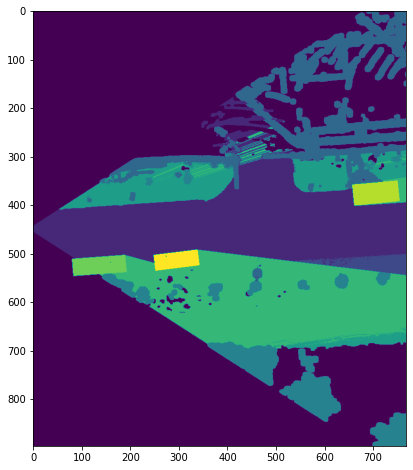

In [10]:
plt.imshow(bev_mask)

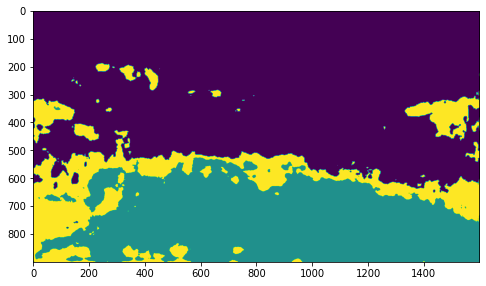

In [11]:
plt.imshow(vf_mask)

In [12]:
front_img.shape

(900, 1600, 3)

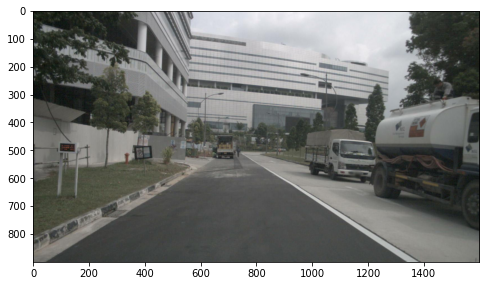

In [13]:
plt.imshow(front_img)

In [23]:
img_size = bev_crop
img_scale = 1
# H_inv = get_init_homography(intrinsics, extrinsics, bev_params, img_scale, img_size)
# print(H_inv)
H = get_init_homography(intrinsics, extrinsics, bev_params, img_scale, img_size)
H

C:\Users\Letian Shi\AppData\Local\Temp\ipykernel_13024\441128754.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [0, np.sin(theta_w2c_x), np.cos(theta_w2c_x)]], dtype=np.float)
C:\Users\Letian Shi\AppData\Local\Temp\ipykernel_13024\441128754.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [-np.sin(theta_w2c_y), 0, np.cos(theta_w

tensor([[-1.0204e-02, -1.6262e-01,  8.8257e+01],
        [-1.2497e-18, -3.8272e-01,  2.0103e+02],
        [ 1.2935e-36, -4.2348e-04,  2.0814e-01]])

In [24]:
H0 = torch.FloatTensor([[0.707,-0.707,0],[0.707,0.707,0],[0,0,1]])

In [25]:
input_img = torch.FloatTensor(front_img).permute(2,0,1).unsqueeze(0) / 256
input_H = H.unsqueeze(0)
print(input_img.shape)
out_ipm = kornia.geometry.transform.warp_perspective(input_img, input_H, (int(bev_crop[0]), int(bev_crop[1])))
out_ipm = torch.rot90(out_ipm, k=2, dims=[2, 3])
print(out_ipm.shape)

torch.Size([1, 3, 900, 1600])
torch.Size([1, 3, 896, 768])


(896, 768, 3)


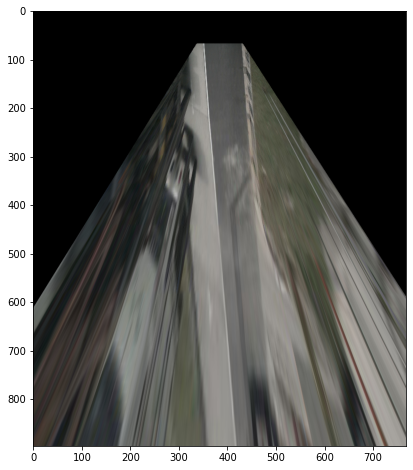

In [26]:
out = out_ipm.squeeze(0).permute(1,2,0).numpy()
np.sum(out != 0)
print(out.shape)
plt.imshow(out)

(768, 896, 3)


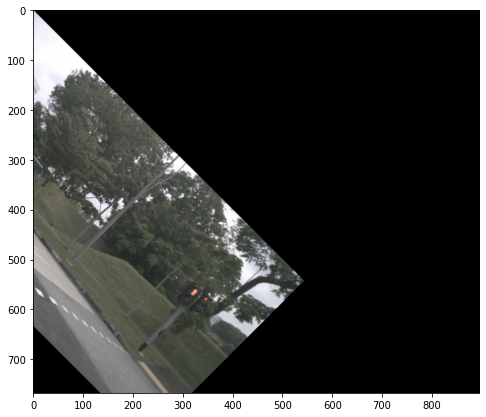

In [158]:
# out = out_ipm.squeeze(0).permute(1,2,0).numpy()
# print(out.shape)
# plt.imshow(out)